# Fashionet.AI Rev 1

an app for clothes classification and colour recognition by Yannis Georgas 5-Jan-2019|

## TABLE OF CONTENTS: 

lets take a look below at the jupyter notebook structure:


#### SECTION 1 Load the trained model
#### SECTION 2 Predict object class using image or camera
#### SECTION 3 Understand the dominant colours of the object using k-means
#### SECTION 4: What next? 

## SECTION 1 Load the trained Model

Lets load our pre-trained model here

In [1]:
import cv2
import numpy as np
from keras.models import load_model, Model

#for MacOS the below lines required to run without jupyter notebook crashing
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
my_model = load_model('fashion_model.h5')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


You can also print a summary of your model by running the following code.

In [3]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

----------------------------------------------------------------------------------------------------------

## SECTION 2 Predict object class using image or camera

Now that the trained model is loaded lets see our photo that we wish to classify

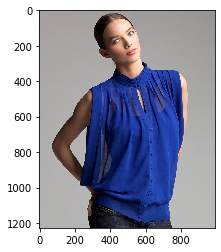

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

image = Image.open('./blousetest.jpg')

plt.imshow(image)

In [4]:
class_names = ['Blouse', 'Hoodie', 'T-Shirt']
width = 250
height = 250

we open the camera to do classification of what we wear:

In [7]:
import time 

# get the reference to the webcam
camera = cv2.VideoCapture(0)
camera_height = 500

while(True):
    # read a new frame
    _, frame = camera.read()
    
    # flip the frameq
    frame = cv2.flip(frame, 1)

    # rescaling camera output
    aspect = frame.shape[1] / float(frame.shape[0])
    res = int(aspect * camera_height) # landscape orientation - wide image
    frame = cv2.resize(frame, (res, camera_height))

    # add rectangle
    cv2.rectangle(frame, (300, 75), (650, 425), (240, 100, 0), 2)

    # get ROI
    roi = frame[75+2:425-2, 300+2:650-2]
    
    # parse BRG to RGB
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    # resize
    roi = cv2.resize(roi, (width, height))
    
    # predict!
    roi_X = np.expand_dims(roi, axis=0)

    predictions = my_model.predict(roi_X)
    type_1_pred, type_2_pred, type_3_pred = predictions[0]   

    # Blouse
    type_1_text = '{}: {}%'.format(class_names[0], int(type_1_pred*100))
    cv2.putText(frame, type_1_text, (70, 170), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240, 240, 240), 2)

    # Hoodie
    type_2_text = '{}: {}%'.format(class_names[1], int(type_2_pred*100))
    cv2.putText(frame, type_2_text, (70, 200), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240, 240, 240), 2)

    # Shirt
    type_3_text = '{}: {}%'.format(class_names[2], int(type_3_pred*100))
    cv2.putText(frame, type_3_text, (70, 230), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240, 240, 240), 2)
    
    # show the frame
    cv2.imshow("Test out", frame)

    key = cv2.waitKey(1)

    # quit camera if 'q' key is pressed
    if key & 0xFF == ord("q"):
        break

camera.release()
cv2.destroyAllWindows()

or we can load a photo from our computer to classify it

Input image shape: (1, 250, 250, 3)
 P = [Blouses, Hoodies, Tshirts]
class prediction P = [[1. 0. 0. 0. 0. 0.]]


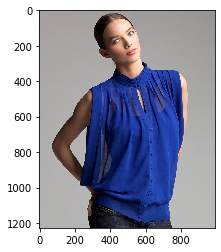

In [6]:
import numpy as np

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import imageio

#test_model = load_model('fine_tune_model_DvCvS.h5')
#img = load_img('image_to_predict.jpg',False,target_size=(img_width,img_height))

img_width,img_height = 250, 250

img_path = 'blousetest.jpg'
img = load_img(img_path,False,target_size=(img_width,img_height))  # parameter: grayscale=False
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
print('Input image shape:', x.shape)
                            #preds = test_model.predict_classes(x)
                            #prob = test_model.predict_proba(x)
                            #print(preds, probs)
my_image = imageio.imread(img_path)
imshow(my_image)
print(' P = [Blouses, Hoodies, Tshirts]')
print("class prediction P =", my_model.predict(x))

----------------------------------------------------------------------------------------------------------

## SECTION 3 Understand the dominant colours of the object using k-means (taken from rmotr.com)

Now we will use k-means algorithm to find the colours of the photo used above

In [7]:
import os
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image
from collections import Counter
from sklearn.cluster import KMeans

%matplotlib inline

Changing the RGB to HTML Hex Color Codes

https://www.w3schools.com/colors/colors_hexadecimal.asp

In [8]:
# Utility function, rgb to hex
def rgb2hex(rgb):
    hex = "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
    return hex


Image color extraction using Scikit Learn

We'll see how simple it is to identify the most important colors in an image using the K Means, unsupervised ML model from the Scikit Learn package.

Step 1: Define some meta variables

You can play around with the following variables to generate different results. CLUSTERS is probably the most important one, as it defines the number of colors we'll extract from the image.


In [9]:
PATH = './blousetest.jpg'
WIDTH = 250
HEIGHT = 250
CLUSTERS = 6   # max number of colours (clusters of colours) we would like to identify 

Step 2: Open the image using Pillow

We'll use the Pillow library to open and manipulate the image.

In [10]:
image = Image.open(PATH)

In [11]:
image.size

(990, 1228)

In [12]:
print("Loaded {f} image. Size: {s:.2f} KB. Dimensions: ({d})".format(
    f=image.format, s=os.path.getsize(PATH) / 1024, d=image.size))

Loaded JPEG image. Size: 173.02 KB. Dimensions: ((990, 1228))


Step 3: Resize image

The ML model will take considerably longer if the image is large. We'll try to resize it keeping the aspect ratio.

In [13]:
def calculate_new_size(image):
    if image.width >= image.height:
        wpercent = (WIDTH / float(image.width))
        hsize = int((float(image.height) * float(wpercent)))
        new_width, new_height = WIDTH, hsize
    else:
        hpercent = (HEIGHT / float(image.height))
        wsize = int((float(image.width) * float(hpercent)))
        new_width, new_height = wsize, HEIGHT
    return new_width, new_height

In [14]:
calculate_new_size(image)

(201, 250)

In [15]:
new_width, new_height = calculate_new_size(image)

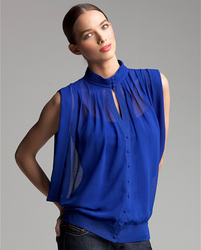

In [16]:
image.resize((new_width, new_height), Image.ANTIALIAS)

In [17]:
image = image.resize((new_width, new_height), Image.ANTIALIAS)

Step 4: Creating the numpy arrays

Our ML Model needs the image as an array of pixels. We explained this in detail in one of our workshops.

https://www.youtube.com/watch?v=2Q4L3MtdAbY

In [18]:
img_array = np.array(image)

In [19]:
img_vector = img_array.reshape((img_array.shape[0] * img_array.shape[1], 3))

Step 5: Create the model and train it

We're ready for the true ML part. We'll create a model using N clusters and extract the colors.

In [20]:
model = KMeans(n_clusters=CLUSTERS)

labels = model.fit_predict(img_vector)

label_counts = Counter(labels)

total_count = sum(label_counts.values())

These are the colors extracted:

In [21]:
hex_colors = [
    rgb2hex(center) for center in model.cluster_centers_
]
hex_colors

['#b9b5b1', '#122469', '#a5a29f', '#233e9f', '#0d0e26', '#573d35']

And this is the proportion of each color:

In [22]:
list(zip(hex_colors, list(label_counts.values())))

[('#b9b5b1', 15126),
 ('#122469', 3424),
 ('#a5a29f', 3912),
 ('#233e9f', 13629),
 ('#0d0e26', 8599),
 ('#573d35', 5560)]

Final Result:

We can see now the final result of the color extracted:

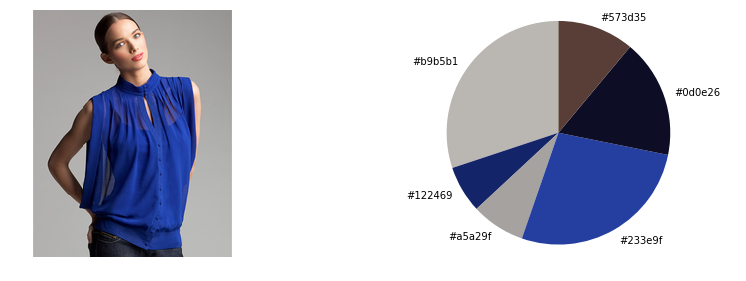

In [23]:
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.imshow(image)
plt.axis('off')

plt.subplot(222)
plt.pie(label_counts.values(), labels=hex_colors, colors=[color / 255 for color in model.cluster_centers_], startangle=90)
plt.axis('equal')
plt.show()

----------------------------------------------------------------------------------------------------------

# SECTION 4: What Next?

An improved version of this app would do object detection instead of classification. By doing object detection the model will cut out the object instead of just processing the whole photo and hence the k-means algorithm will identify the colours of the object alone. if you noticed in section 3, one of the dominant colours of the photo is grey however thats the background colour not a colour of the blouse.

So, to conclude, with this app we were able to classify a photo to one of the following classes: blouse, t-shirt or hoodie and identify the dominant colours. If you have photos of jeans, shoes, bags etc you can train your model to identify more classes and then start combining different class objects according to their colour to create a look, i.e. blue blouse matching black jeans etc.  